# Image classification machine learning algorithm
## Platinum cyclic voltammetry scan facet detection through image classification

Developed by: Heather Baroody and Tasleem Muzaffar
17 May 2018

This is a general image classification model that is trained to distingush between four distinct Platinum cyclic voltammetry scans for different surface facets: Pt(111), Pt(110), Pt(100), and polycrystalline Pt.  This was developed during this 2018 ECS Data Hack Week in Seattle so the goal is to develop a simple model in the short amount of time we have and expand it later. 

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from sklearn.decomposition import PCA
from PIL import Image

### Pre - Image proccessing and standardizing data

The inital data sets were created by extracting Pt(jkl) CV data point from a variety of literature studies as a principal of proof. The images are standardized by converting the .jpg to grayscale and resizing. In the future the goal is to use actual images of CV scans in literature with the hope of having >50 images per Pt facet.

In [2]:
img = Image.open("pt111-1.jpg").convert('I')
arr = np.array(img)
arr.shape
imgrs = img.resize((100, 100))
arrrs = np.array(imgrs)
print (arrrs)
imgrs.show()

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]


## Building the Model
### Processing the entire training/test set
Loop through and process all images in for training/test set and convert to a matrix with number of rows = number of samples.

In [3]:
#Image files

#Pt(111) convert to grayscale
Pt_111_01 = Image.open("pt111-1.jpg").convert('I')
Pt_111_02 = Image.open("pt111-2.jpg").convert('I')
Pt_111_03 = Image.open("pt111-3.jpg").convert('I')
Pt_111_04 = Image.open("pt111-4.jpg").convert('I')
Pt_111_05 = Image.open("pt111-5.jpg").convert('I')
Pt_111_06 = Image.open("pt111-6.jpg").convert('I')
Pt_111_07 = Image.open("pt111-7.jpg").convert('I')
Pt_111_08 = Image.open("pt111-8.jpg").convert('I')
Pt_111_09 = Image.open("pt111-9.jpg").convert('I')
#Pt_111_10 = Image.open("pt111-10.jpg").convert('I')
Pt_111_11 = Image.open("pt111-11.jpg").convert('I')
Pt_111_12 = Image.open("pt111-12.jpg").convert('I')

#Pt(110)
Pt_110_01 = Image.open("pt110-1.jpg").convert('I')
Pt_110_02 = Image.open("pt110-2.jpg").convert('I')
Pt_110_03 = Image.open("pt110-3.jpg").convert('I')
Pt_110_04 = Image.open("pt110-4.jpg").convert('I')
Pt_110_05 = Image.open("pt110-5.jpg").convert('I')
Pt_110_06 = Image.open("pt110-6.jpg").convert('I')

#Pt(100)
Pt_100_01 = Image.open("pt100-1.jpg").convert('I')
Pt_100_02 = Image.open("pt100-2.jpg").convert('I')
Pt_100_03 = Image.open("pt100-3.jpg").convert('I')
Pt_100_04 = Image.open("pt100-4.jpg").convert('I')
Pt_100_05 = Image.open("pt100-5.jpg").convert('I')
Pt_100_06 = Image.open("pt100-6.jpg").convert('I')

#Pt(poly)
Pt_poly_01 = Image.open("ptpoly-1.jpg").convert('I')
Pt_poly_02 = Image.open("ptpoly-2.jpg").convert('I')
Pt_poly_03 = Image.open("ptpoly-3.jpg").convert('I')
Pt_poly_04 = Image.open("ptpoly-4.jpg").convert('I')
Pt_poly_05 = Image.open("ptpoly-5.jpg").convert('I')
Pt_poly_06 = Image.open("ptpoly-6.jpg").convert('I')


images = [Pt_111_01, Pt_111_02, Pt_111_03, Pt_111_04, 
         Pt_111_05, Pt_111_06,  Pt_111_07,Pt_111_08, 
         Pt_111_09, Pt_111_11, Pt_111_12, Pt_110_01,
         Pt_110_02, Pt_110_03, Pt_110_04, Pt_110_05,Pt_110_06, Pt_100_01,
         Pt_100_02, Pt_100_03, Pt_100_04, Pt_100_05, Pt_100_06, Pt_poly_01,
         Pt_poly_02, Pt_poly_03, Pt_poly_04, Pt_poly_05, Pt_poly_06]

#resize image files
x_pix = 100
y_pix = 100
image_rs = []

for i in images:
    image_rs.append(i.resize((x_pix, y_pix)))


#convert to array
image_ar = []
for j in image_rs:
    image_ar.append(np.array(j))

image_ar = np.array(image_ar)
print(image_ar.shape)

(29, 100, 100)


In [4]:
# resize matrix for use in algorithm
dim = np.dot(image_ar.shape[1],image_ar.shape[2])
data = np.reshape(image_ar, (image_ar.shape[0], dim))
data.shape

(29, 10000)

### Define target values
Create the vector of target values that correlate to the data and corresponding target names.

In [5]:
#Define target values
target = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3])

facet = ['Pt (111)', 'Pt(110)', 'Pt(100)', 'Pt(poly)']
print(target.shape)

(29,)


Split data into training set and test set

In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target,
                                                random_state=2)
print(Xtrain.shape, Xtest.shape)

((21, 10000), (8, 10000))


## Applying and comparing various learning alogorithms
### 1 - Logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

Check accuracy score

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.875

Validate model

In [9]:
test = np.array([data[25]])
test.shape
usertest = clf.predict(test)

print (facet[usertest])
#clf.predict_proba(test)

Pt(poly)


/Users/heatherbaroody/miniconda3/envs/ECStutorial/lib/python2.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  """


### 2 - K nearest neighbors classifier

In [10]:
from sklearn import neighbors

# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(data, target)


test = np.array([data[13]])
test.shape
usertest = clf.predict(test)

result = knn.predict(test)

print(facet[result])

knn.predict_proba(test)

Pt(110)


/Users/heatherbaroody/miniconda3/envs/ECStutorial/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


array([[ 0. ,  0.8,  0.2,  0. ]])

Check accuracy score

In [11]:
knn.score(data, target, sample_weight=None)

0.82758620689655171

### 3 - unsupervised Isomap

In [12]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
data_projected = iso.fit_transform(data)
data_projected.shape

(29, 2)

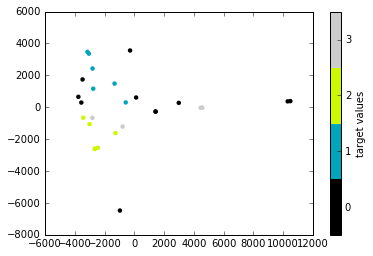

In [13]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=target,
            edgecolor='none', alpha=1, cmap=plt.cm.get_cmap('nipy_spectral', 4));
plt.colorbar(label='target values', ticks=range(4))
plt.clim(-0.5, 3.5)

## Model Accuracy visulaization

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(image_ar.shape[1], image_ar.shape[2]))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].reshape(image_ar.shape[1], image_ar.shape[2]), cmap='binary')
    ax.text(10, 10, str(ypred[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == ypred[i]) else 'red')
    ax.set_xticks([])
    ax.set_yticks([])